In [1]:
import os
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from python.data import Dataloader
from python.models import RandomExampleModel
from python.metrics import PairsExplained, ClusterIntersection

In [3]:
# Loading the data
data_loader = Dataloader("../data/dataset_10") # Specify path to the dataset you want to load
X, Y = data_loader.load()
Z = data_loader.get_ground_truth_labels()
print(X.shape)
print(Y.shape)
print(Z.shape)

(40002, 10)
(40002, 10)
(40002,)


In [4]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data
print(X.shape)

(40002, 10)


In [5]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.0172     -0.17280946]
 [ 0.1904899   0.05389895]
 [-0.18002516 -0.11719372]
 [ 0.24068762  0.22920997]
 [ 0.14951786  0.09248784]]


In [6]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [7]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.4


In [8]:
# Or we call directly the right metric:
pairs_explained = PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.6719664016799161
Percentage of explained preferences for all samples: 0.6719664016799161


In [9]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 1 0 0]


In [10]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[1 0 2 1 0]


In [11]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.5236179280008775
Cluster intersection for all samples: 0.5236179280008775


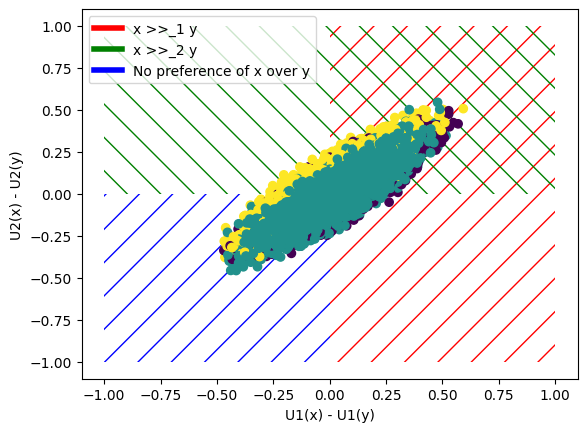

In [12]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [14]:
from python.models import HeuristicModel

# matrix_results = []
# for cluster in range(2, 10):
#     list_temp = []
#     for l in range(5, 10):
#         model = HeuristicModel(n_clusters=cluster, n_pieces=l, nb_iterations=5)
#         model.fit(X[:200], Y[:200])
#         list_temp.append([pairs_explained.from_model(model, X, Y), cluster_intersection.from_model(model, X, Y, Z)])
#     matrix_results.append(list_temp)
# print(matrix_results)

l = 5
matrix_results = []
for cluster in range(3, 10):
    model = HeuristicModel(n_clusters=cluster, n_pieces=l, nb_iterations=5)
    model.fit(X, Y)
    matrix_results.append([pairs_explained.from_model(model, X, Y), cluster_intersection.from_model(model, X, Y, Z)])
print(matrix_results)


# model = HeuristicModel(n_clusters=3, n_pieces=5, nb_iterations=5)
# model.fit(X, Y)

# print(model.list_results)
# Uncomment once your model is working
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 983 rows, 1580 columns and 23547 nonzeros
Model fingerprint: 0x982dd1d9
Variable types: 980 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 17.0957623
Presolve removed 60 rows and 630 columns
Presolve time: 0.04s
Presolved: 923 rows, 950 columns, 19530 nonzeros
Found heuristic solution: objective 9.6893119
Variable types: 350 continuous, 600 integer (600 binary)

Root relaxation: objective 0.000000e+00, 381 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Ob

  0%|          | 0/5 [00:00<?, ?it/s]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 24811 rows, 61935 columns and 479871 nonzeros
Model fingerprint: 0xce942287
Variable types: 49560 continuous, 12375 integer (12375 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 988.7189054
Presolve removed 12395 rows and 49510 columns
Presolve time: 0.79s
Presolved: 12416 rows, 12425 columns, 373582 nonzeros
Variable types: 12425 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.20s

Solved with dual simplex

Root relaxation: objective 3.121615e+01, 3108 iterations, 2.85

 20%|██        | 1/5 [00:45<03:03, 45.83s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 50004 rows, 124825 columns and 967209 nonzeros
Model fingerprint: 0x515a3ae8
Variable types: 99884 continuous, 24941 integer (24941 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 27.1452 (3.79s)
MIP start from previous solve produced solution with objective 27.1452 (3.81s)
Loaded MIP start from previous solve with objective 27.1452
Processed MIP start in 3.81 seconds (4.36 work units)

Presolve removed 37396 rows and 112208 columns
Presolve time: 0.34s
Presolved: 12608 rows, 12617 columns, 379666 nonzeros
Variable types: 12616 continuous, 1

 40%|████      | 2/5 [01:41<02:34, 51.67s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 73917 rows, 184515 columns and 1429638 nonzeros
Model fingerprint: 0x1c3b9b3b
Variable types: 147648 continuous, 36867 integer (36867 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 10s
Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 15s
MIP start from previous solve produced solution with objective 21.3721 (15.14s)
MIP start from previous solve produced solution with objective 21.3721

 60%|██████    | 3/5 [02:54<02:02, 61.14s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 96616 rows, 241170 columns and 1868398 nonzeros
Model fingerprint: 0x42f075f7
Variable types: 192984 continuous, 48186 integer (48186 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 18.4647 (4.07s)
MIP start from previous solve produced solution with objective 18.4647 (4.12s)
Loaded MIP start from previous solve with objective 18.4647
Processed MIP start in 4.10 seconds (5.02 work units)

Presolve removed 85256 rows and 218482 columns
Presolve time: 0.29s
Presolved: 11360 rows, 22688 columns, 353603 nonzeros
Variable types: 22688 continuous,

 80%|████████  | 4/5 [03:44<00:56, 56.86s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 118523 rows, 295845 columns and 2291763 nonzeros
Model fingerprint: 0xc355634a
Variable types: 236736 continuous, 59109 integer (59109 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 17.7517 (2.79s)
MIP start from previous solve produced solution with objective 17.7517 (2.84s)
Loaded MIP start from previous solve with objective 17.7517
Processed MIP start in 2.83 seconds (3.20 work units)

Presolve removed 107559 rows and 273949 columns
Presolve time: 0.37s
Presolved: 10964 rows, 21896 columns, 341337 nonzeros
Variable types: 21896 continuou

100%|██████████| 5/5 [04:31<00:00, 54.31s/it]


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1244 rows, 1840 columns and 31396 nonzeros
Model fingerprint: 0x0ee04f91
Variable types: 1040 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 16.1174164
Presolve removed 80 rows and 640 columns
Presolve time: 0.03s
Presolved: 1164 rows, 1200 columns, 26040 nonzeros
Found heuristic solution: objective 9.1395619
Variable types: 400 continuous, 800 integer (800 binary)

Root relaxation: objective 0.000000e+00, 383 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |

  0%|          | 0/5 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 22771 rows, 56835 columns and 441435 nonzeros
Model fingerprint: 0x757d56f4
Variable types: 45480 continuous, 11355 integer (11355 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1047.5144114
Presolve removed 11375 rows and 45430 columns
Presolve time: 0.52s
Presolved: 11396 rows, 11405 columns, 340430 nonzeros
Variable types: 11405 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.32s (can be av

 20%|██        | 1/5 [00:36<02:24, 36.23s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 41678 rows, 104010 columns and 807961 nonzeros
Model fingerprint: 0x6169a978
Variable types: 83232 continuous, 20778 integer (20778 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.488763 (1.68s)
MIP start from previous solve produced solution with objective 0.488762 (1.70s)
Loaded MIP start from previous solve with objective 0.488762
Processed MIP start in 1.69 seconds (2.97 work units)

Presolve removed 32213 rows and 94536 columns
Presolve time: 0.17s
Presolved: 9465 rows, 9474 columns, 281870 nonzeros
Found heuristic solution: objective

 40%|████      | 2/5 [01:16<01:55, 38.42s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 60715 rows, 151510 columns and 1177056 nonzeros
Model fingerprint: 0x57577f14
Variable types: 121244 continuous, 30266 integer (30266 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.486719 (2.25s)
MIP start from previous solve produced solution with objective 0.486718 (2.27s)
Loaded MIP start from previous solve with objective 0.486718
Processed MIP start in 2.25 seconds (3.97 work units)

Presolve removed 51186 rows and 132484 columns
Presolve time: 0.16s
Presolved: 9529 rows, 19026 columns, 293382 nonzeros
Variable types: 19026 continuou

 60%|██████    | 3/5 [02:00<01:21, 40.96s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 79642 rows, 198735 columns and 1544019 nonzeros
Model fingerprint: 0x40918d45
Variable types: 159036 continuous, 39699 integer (39699 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.488081 (1.99s)
MIP start from previous solve produced solution with objective 0.488078 (2.02s)
Loaded MIP start from previous solve with objective 0.488078
Processed MIP start in 2.01 seconds (3.14 work units)

Presolve removed 70168 rows and 179819 columns
Presolve time: 0.21s
Presolved: 9474 rows, 18916 columns, 291651 nonzeros
Variable types: 18916 continuou

 80%|████████  | 4/5 [02:43<00:42, 42.05s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 98479 rows, 245735 columns and 1909138 nonzeros
Model fingerprint: 0x4a52705e
Variable types: 196648 continuous, 49087 integer (49087 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.389626 (1.85s)
MIP start from previous solve produced solution with objective 0.389621 (1.89s)
Loaded MIP start from previous solve with objective 0.389621
Processed MIP start in 1.88 seconds (3.06 work units)

Presolve removed 89050 rows and 226909 columns
Presolve time: 0.24s
Presolved: 9429 rows, 18826 columns, 290195 nonzeros
Found heuristic solution: objec

100%|██████████| 5/5 [03:26<00:00, 41.30s/it]


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1505 rows, 2100 columns and 39245 nonzeros
Model fingerprint: 0x3f5a9769
Variable types: 1100 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 15.4785824
Presolve removed 100 rows and 650 columns
Presolve time: 0.04s
Presolved: 1405 rows, 1450 columns, 32550 nonzeros
Found heuristic solution: objective 9.6632591
Variable types: 450 continuous, 1000 integer (1000 binary)

Root relaxation: objective 0.000000e+00, 366 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Une

  0%|          | 0/5 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16319 rows, 40705 columns and 315127 nonzeros
Model fingerprint: 0xd93ecfc4
Variable types: 32576 continuous, 8129 integer (8129 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 780.3627849
Presolve removed 8149 rows and 32526 columns
Presolve time: 0.38s
Presolved: 8170 rows, 8179 columns, 245263 nonzeros
Variable types: 8179 continuous, 0 integer (0 binary)

Root relaxation: objective 9.631246e+00, 743 iterations, 0.53 seconds (1.22 work units)

    Nodes    |    Current Node    |     Object

 20%|██        | 1/5 [00:38<02:35, 38.80s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31592 rows, 78795 columns and 609898 nonzeros
Model fingerprint: 0xdaa7957b
Variable types: 63060 continuous, 15735 integer (15735 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 1.84953 (0.71s)
MIP start from previous solve produced solution with objective 1.84953 (0.72s)
Loaded MIP start from previous solve with objective 1.84953

Presolve removed 23945 rows and 71139 columns
Presolve time: 0.39s
Presolved: 7647 rows, 7656 columns, 229404 nonzeros
Variable types: 7656 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 785 iteration

 40%|████      | 2/5 [01:22<02:05, 41.87s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 46881 rows, 116925 columns and 905111 nonzeros
Model fingerprint: 0xc08b524f
Variable types: 93576 continuous, 23349 integer (23349 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 2.09898 (0.73s)
MIP start from previous solve produced solution with objective 2.09898 (0.74s)
Loaded MIP start from previous solve with objective 2.09898

Presolve removed 39226 rows and 109261 columns
Presolve time: 0.19s
Presolved: 7655 rows, 7664 columns, 229795 nonzeros
Variable types: 7664 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 404 iterati

 60%|██████    | 3/5 [02:07<01:26, 43.20s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 62558 rows, 156025 columns and 1208068 nonzeros
Model fingerprint: 0x15024d69
Variable types: 124868 continuous, 31157 integer (31157 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 1.69126 (0.90s)
MIP start from previous solve produced solution with objective 1.69126 (0.94s)
Loaded MIP start from previous solve with objective 1.69126

Presolve removed 54709 rows and 140359 columns
Presolve time: 0.19s
Presolved: 7849 rows, 15666 columns, 243780 nonzeros
Variable types: 15666 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 352 ite

 80%|████████  | 4/5 [02:53<00:44, 44.09s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 78199 rows, 195035 columns and 1510722 nonzeros
Model fingerprint: 0xf86940bf
Variable types: 156088 continuous, 38947 integer (38947 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.94175 (0.96s)
MIP start from previous solve produced solution with objective 0.94175 (0.99s)
Loaded MIP start from previous solve with objective 0.94175

Presolve removed 70368 rows and 179405 columns
Presolve time: 0.23s
Presolved: 7831 rows, 15630 columns, 243590 nonzeros
Variable types: 15630 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 467 ite

100%|██████████| 5/5 [03:38<00:00, 43.75s/it]


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1766 rows, 2360 columns and 47094 nonzeros
Model fingerprint: 0x93c6296d
Variable types: 1160 continuous, 1200 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 20.3082471
Presolve removed 120 rows and 660 columns
Presolve time: 0.06s
Presolved: 1646 rows, 1700 columns, 39060 nonzeros
Found heuristic solution: objective 10.3655709
Variable types: 500 continuous, 1200 integer (1200 binary)

Root relaxation: objective 0.000000e+00, 366 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

  0%|          | 0/5 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16515 rows, 41195 columns and 319331 nonzeros
Model fingerprint: 0x1a5f3a9e
Variable types: 32968 continuous, 8227 integer (8227 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 932.7387199
Presolve removed 8247 rows and 32918 columns
Presolve time: 0.39s
Presolved: 8268 rows, 8277 columns, 247780 nonzeros
Variable types: 8277 continuous, 0 integer (0 binary)

Root relaxation: objective 2.980605e+00, 588 iterations, 0.24 seconds (0.47 work units)

    Nodes    |    Current Node    |     Object

 20%|██        | 1/5 [00:43<02:55, 43.89s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31756 rows, 79205 columns and 613480 nonzeros
Model fingerprint: 0x2d32ba00
Variable types: 63388 continuous, 15817 integer (15817 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.889533 (0.62s)
MIP start from previous solve produced solution with objective 0.889533 (0.63s)
Loaded MIP start from previous solve with objective 0.889533

Presolve removed 24125 rows and 71565 columns
Presolve time: 0.40s
Presolved: 7631 rows, 7640 columns, 227950 nonzeros
Variable types: 7640 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 434 iterat

 40%|████      | 2/5 [01:31<02:18, 46.09s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 46679 rows, 116420 columns and 901065 nonzeros
Model fingerprint: 0x74b654ae
Variable types: 93172 continuous, 23248 integer (23248 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.128087 (0.66s)
MIP start from previous solve produced solution with objective 0.128087 (0.68s)
Loaded MIP start from previous solve with objective 0.128087

Presolve removed 39207 rows and 108939 columns
Presolve time: 0.21s
Presolved: 7472 rows, 7481 columns, 222733 nonzeros
Variable types: 7481 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 226 iter

 60%|██████    | 3/5 [02:20<01:34, 47.26s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 61828 rows, 154200 columns and 1192980 nonzeros
Model fingerprint: 0x7d42cb9f
Variable types: 123408 continuous, 30792 integer (30792 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.102242 (0.86s)
MIP start from previous solve produced solution with objective 0.102242 (0.88s)
Loaded MIP start from previous solve with objective 0.102242

Presolve removed 54243 rows and 139062 columns
Presolve time: 0.19s
Presolved: 7585 rows, 15138 columns, 233676 nonzeros
Variable types: 15138 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 319 

 80%|████████  | 4/5 [03:09<00:48, 48.13s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 77005 rows, 192050 columns and 1485396 nonzeros
Model fingerprint: 0x2855e2ff
Variable types: 153700 continuous, 38350 integer (38350 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.0844605 (0.78s)
Loaded MIP start from previous solve with objective 0.0844605

Presolve removed 69406 rows and 176884 columns
Presolve time: 0.22s
Presolved: 7599 rows, 15166 columns, 234096 nonzeros
Variable types: 15166 continuous, 0 integer (0 binary)

Root relaxation: interrupted, 364 iterations, 0.18 seconds (0.29 work units)

    Nodes    |    Current Nod

100%|██████████| 5/5 [03:59<00:00, 47.86s/it]


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2027 rows, 2620 columns and 54943 nonzeros
Model fingerprint: 0xc8b88388
Variable types: 1220 continuous, 1400 integer (1400 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 14.9989147
Presolve removed 140 rows and 670 columns
Presolve time: 0.06s
Presolved: 1887 rows, 1950 columns, 45570 nonzeros
Found heuristic solution: objective 8.3101619
Variable types: 550 continuous, 1400 integer (1400 binary)

Root relaxation: objective 0.000000e+00, 366 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Une

  0%|          | 0/5 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 7675 rows, 19095 columns and 146101 nonzeros
Model fingerprint: 0x2bdc789a
Variable types: 15288 continuous, 3807 integer (3807 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 158.0870328
Presolve removed 3827 rows and 15238 columns
Presolve time: 0.15s
Presolved: 3848 rows, 3857 columns, 113100 nonzeros
Variable types: 3857 continuous, 0 integer (0 binary)

Root relaxation: objective 3.014842e-02, 148 iterations, 0.05 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objecti

 20%|██        | 1/5 [00:48<03:12, 48.04s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 14656 rows, 36455 columns and 278741 nonzeros
Model fingerprint: 0x34bfd946
Variable types: 29188 continuous, 7267 integer (7267 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.24s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.25 seconds (0.18 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi Op

 40%|████      | 2/5 [01:38<02:27, 49.25s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 21791 rows, 54200 columns and 414559 nonzeros
Model fingerprint: 0x06ed7443
Variable types: 43396 continuous, 10804 integer (10804 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.24s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.26 seconds (0.20 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi 

 60%|██████    | 3/5 [02:30<01:40, 50.46s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 29436 rows, 73220 columns and 560189 nonzeros
Model fingerprint: 0x0ca13e18
Variable types: 58624 continuous, 14596 integer (14596 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.30s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.32 seconds (0.21 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi 

 80%|████████  | 4/5 [03:22<00:51, 51.15s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 37179 rows, 92485 columns and 707706 nonzeros
Model fingerprint: 0x55d35647
Variable types: 74048 continuous, 18437 integer (18437 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.32s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.34 seconds (0.23 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi 

100%|██████████| 5/5 [04:14<00:00, 50.84s/it]


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2288 rows, 2880 columns and 62792 nonzeros
Model fingerprint: 0x85802be0
Variable types: 1280 continuous, 1600 integer (1600 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 18.2841525
Presolve removed 160 rows and 680 columns
Presolve time: 0.07s
Presolved: 2128 rows, 2200 columns, 52080 nonzeros
Found heuristic solution: objective 11.3214088
Variable types: 600 continuous, 1600 integer (1600 binary)

Root relaxation: objective 0.000000e+00, 366 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

  0%|          | 0/5 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3039 rows, 7505 columns and 56985 nonzeros
Model fingerprint: 0xff74e3b3
Variable types: 6016 continuous, 1489 integer (1489 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 83.9557867
Presolve removed 1509 rows and 5966 columns
Presolve time: 0.05s
Presolved: 1530 rows, 1539 columns, 44820 nonzeros
Found heuristic solution: objective 47.8975386
Variable types: 1539 continuous, 0 integer (0 binary)

Root relaxation: objective 9.083868e-02, 144 iterations, 0.02 seconds (0.03 work units)

    No

 20%|██        | 1/5 [00:52<03:29, 52.29s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6430 rows, 15890 columns and 120783 nonzeros
Model fingerprint: 0x9b497310
Variable types: 12736 continuous, 3154 integer (3154 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.0113807 (0.11s)
MIP start from previous solve produced solution with objective 0.0113807 (0.11s)
Loaded MIP start from previous solve with objective 0.0113807

Presolve removed 4724 rows and 14175 columns
Presolve time: 0.06s
Presolved: 1706 rows, 1715 columns, 50080 nonzeros
Variable types: 1715 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 148 iteratio

 40%|████      | 2/5 [01:46<02:40, 53.34s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9607 rows, 23740 columns and 180378 nonzeros
Model fingerprint: 0xc7c7d168
Variable types: 19028 continuous, 4712 integer (4712 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.11s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.09 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi Opt

 60%|██████    | 3/5 [02:41<01:48, 54.20s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13460 rows, 33280 columns and 253002 nonzeros
Model fingerprint: 0xdeb68f4e
Variable types: 26672 continuous, 6608 integer (6608 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.13s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.11 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi Op

 80%|████████  | 4/5 [03:37<00:54, 54.99s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17581 rows, 43490 columns and 330806 nonzeros
Model fingerprint: 0xebd86d5b
Variable types: 34852 continuous, 8638 integer (8638 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.16s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.17 seconds (0.13 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi Op

100%|██████████| 5/5 [04:33<00:00, 54.70s/it]


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2549 rows, 3140 columns and 70641 nonzeros
Model fingerprint: 0xea2c1e43
Variable types: 1340 continuous, 1800 integer (1800 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 17.9452834
Presolve removed 180 rows and 690 columns
Presolve time: 0.08s
Presolved: 2369 rows, 2450 columns, 58590 nonzeros
Found heuristic solution: objective 8.8790509
Variable types: 650 continuous, 1800 integer (1800 binary)

Root relaxation: objective 0.000000e+00, 366 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Une

  0%|          | 0/5 [00:00<?, ?it/s]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10523 rows, 26215 columns and 201859 nonzeros
Model fingerprint: 0x0d0cb048
Variable types: 20984 continuous, 5231 integer (5231 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 626.0236173
Presolve removed 5251 rows and 20934 columns
Presolve time: 0.24s
Presolved: 5272 rows, 5281 columns, 155635 nonzeros
Variable types: 5281 continuous, 0 integer (0 binary)

Root relaxation: objective 2.632994e-01, 412 iterations, 0.12 seconds (0.22 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

 20%|██        | 1/5 [00:57<03:48, 57.23s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 21038 rows, 52410 columns and 403364 nonzeros
Model fingerprint: 0x649a0603
Variable types: 41952 continuous, 10458 integer (10458 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0.253778 (0.41s)
MIP start from previous solve produced solution with objective 0.253778 (0.42s)
Loaded MIP start from previous solve with objective 0.253778

Presolve removed 15770 rows and 47133 columns
Presolve time: 0.25s
Presolved: 5268 rows, 5277 columns, 155153 nonzeros
Variable types: 5277 continuous, 0 integer (0 binary)

Root relaxation: cutoff, 399 iterat

 40%|████      | 2/5 [01:58<02:58, 59.60s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 30765 rows, 76635 columns and 589531 nonzeros
Model fingerprint: 0xcd3d66f3
Variable types: 61344 continuous, 15291 integer (15291 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.41s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.44 seconds (0.34 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi 

 60%|██████    | 3/5 [02:57<01:58, 59.35s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 40978 rows, 102075 columns and 785156 nonzeros
Model fingerprint: 0xc92bdfde
Variable types: 81708 continuous, 20367 integer (20367 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.46s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.49 seconds (0.37 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurobi

 80%|████████  | 4/5 [03:57<00:59, 59.43s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 51585 rows, 128500 columns and 988435 nonzeros
Model fingerprint: 0xea6c9269
Variable types: 102860 continuous, 25640 integer (25640 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.54s)
Loaded MIP start from previous solve with objective 0


Explored 0 nodes (0 simplex iterations) in 0.57 seconds (0.42 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
--- Il y a une solution ---
Gurob

100%|██████████| 5/5 [04:57<00:00, 59.58s/it]


[[0.9550522473876306, 0.6254821680555431], [0.9779761011949403, 0.6242548101089234], [0.983950802459877, 0.6094660017880333], [0.991700414979251, 0.6159219888309352], [0.9986750662466877, 0.6615412248312111], [0.9995750212489376, 0.6706278520728097], [0.9980000999950003, 0.6277113933608587]]
Percentage of explained preferences on train data: 0.9980000999950003
Percentage of preferences well regrouped into clusters: 0.6277113933608587


In [ ]:
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Percentage of explained preferences on train data: 0.955527223638818
Percentage of preferences well regrouped into clusters: 0.6333770159320838


In [ ]:
for cluster in range(3):
    print(len(model.models[cluster].delta_j_k))

22452
26337
23505


In [ ]:
# Pour les itérations qui vont de 1 jusqu'à 14
list_temp = [[0.6502674866256687, 0.566093804757026], [0.8708314584270787, 0.5736255498667281], [0.9052297385130743, 0.578316193062625], [0.9215039248037599, 0.5813184478897602], [0.9264286785660717, 0.5828593323215018], [0.9293785310734464, 0.5856833005203569], [0.9298285085745712, 0.588556312540864], [0.9331033448327584, 0.5913835854918587], [0.9350532473376331, 0.5934690615785453], [0.9364281785910704, 0.5956767060024539], [0.9371031448427578, 0.5979485181137059], [0.9385530723463826, 0.5999390613204771], [0.9402529873506325, 0.6024372077063755], [0.9411529423528824, 0.6052946546442833], [0.9428278586070696, 0.6072679116475416]] # en 25 min, k = 3, l = 5

list_temp_new_init = [[0.9174291285435728, 0.5908782233946476], [0.9348032598370082, 0.6038163605181907], [0.9463276836158192, 0.6137585798393138], [0.9527023648817559, 0.6204919873253356], [0.9550522473876306, 0.6254821680555431], [0.9566521673916304, 0.6287092285219743], [0.9574021298935054, 0.6309042763906404], [0.9576771161441928, 0.6331563999785561], [0.9582020898955053, 0.6351262122401742], [0.9587520623968802, 0.6369728537397534], [0.9590520473976302, 0.6386921597896505], [0.9596020198990051, 0.6399426709997467], [0.9600269986500675, 0.6407216750734674], [0.96045197740113, 0.6414457132696977], [0.9611269436528174, 0.6422581523357521]] # en 27 min
# init avec (la classe) twocluster sur 200 ex, k=3, l=5

list_temp_new_init_several_clusters = [[0.9065046747662617, 0.5836271472344234], [0.912104394780261, 0.5891387126101308], [0.9177541122943853, 0.5940250136314463], [0.9227538623068846, 0.5994042964285125], [0.9274536273186341, 0.6046678266571659], [0.9326533673316334, 0.6097296370150618], [0.9373281335933203, 0.6149354690711504], [0.9419029048547573, 0.6187817280969156], [0.9461276936153192, 0.6214538689330127], [0.9486275686215689, 0.6244430484908093], [0.9510274486275686, 0.6265792007767177], [0.9526273686315684, 0.6286510303869072], [0.9531773411329434, 0.6302354665522143], [0.9551772411379431, 0.6317884400772587], [0.955527223638818, 0.6333770159320838]] # en 30 min
# init avec (la classe) twocluster sur 200 ex, k=3, l=5 en autorisant qu'un pt appartienne à plusieurs clusters

# Pour k et l qui variaient entre 2 et 9, et 5 et 9. (sur 5 iter)
matrix_results_temp = [[[0.8316334183290836, 0.5515081362003998], [0.8323083845807709, 0.5097614285056603], [0.8191590420478976, 0.5096678655230009], [0.8021098945052747, 0.5070037253368451], [0.8263586820658967, 0.515264555764237]], [[0.8820808959552022, 0.579856727520615], [0.8862056897155143, 0.5615577149694302], [0.8848307584620769, 0.5740439759842462], [0.9052047397630119, 0.5619870952653713], [0.9033298335083246, 0.5652114509346656]], [[0.9286285685715714, 0.5881918386268632], [0.9214039298035098, 0.5933340717029547], [0.9356282185890705, 0.5870495130527091], [0.9171041447927604, 0.5975502042377444], [0.903904804759762, 0.596889847515324]], [[0.9388780560971951, 0.6124469494632315], [0.9491025448727564, 0.5991719926015899], [0.9285285735713215, 0.6036116008754199], [0.9407279636018199, 0.6079771309552069], [0.9375781210939453, 0.6121938596952805]], [[0.9533523323833808, 0.6107819568397596], [0.9650517474126293, 0.620176063520016], [0.9670516474176292, 0.6134396600086998], [0.9653767311634418, 0.6171800094778142], [0.9633518324083796, 0.6260746161211976]], [[0.9530273486325683, 0.6287490217874296], [0.9647017649117544, 0.6478451870511647], [0.9614019299035048, 0.626767210425759], [0.9756512174391281, 0.6234982331031445], [0.9433778311084445, 0.6265004579325295]], [[0.9712264386780661, 0.6360144056245601], [0.9697265136743163, 0.6237766434720188], [0.9664516774161291, 0.6312091472749429], [0.964176791160442, 0.626228622070559], [0.9699015049247538, 0.6295294732525942]], [[0.9747262636868157, 0.627525872275172], [0.97977601119944, 0.6356242886338221], [0.9779011049447528, 0.6294262397452363], [0.9825508724563772, 0.6427337216674578], [0.97997600119994, 0.6194931934861221]]] # en 20 min

# l = 5, k variant de 3 à 9
list_new_init_2 = [[0.9550522473876306, 0.6254821680555431], [0.9779761011949403, 0.6242548101089234], [0.983950802459877, 0.6094660017880333], [0.991700414979251, 0.6159219888309352], [0.9986750662466877, 0.6615412248312111], [0.9995750212489376, 0.6706278520728097], [0.9980000999950003, 0.6277113933608587]] # en 40 min sur tout le dataset
matrix_temp_2 = []
for cluster in range(len(matrix_results_temp)):
    list_temp = []
    for l in range(len(matrix_results_temp[0])):
        list_temp.append(matrix_results_temp[cluster][l][0]+matrix_results_temp[cluster][l][1])
    matrix_temp_2.append(list_temp)
matrix_temp_2 = np.array(matrix_temp_2)
print(matrix_temp_2)
print(np.argmax(matrix_temp_2)) # l = 8 et k = 9

# c'est normal que la précision augmente avec L parce que le modèle est plus flexible mais du coup on va fixer L
# on va augmenter le nombre de clusters (pour tester si ça marche tjs)
# on va augmenter le nombre de données à prendre en compte

[[1.38314155 1.34206981 1.32882691 1.30911362 1.34162324]
 [1.46193762 1.4477634  1.45887473 1.46719184 1.46854128]
 [1.51682041 1.514738   1.52267773 1.51465435 1.50079465]
 [1.55132501 1.54827454 1.53214017 1.54870509 1.54977198]
 [1.56413429 1.58522781 1.58049131 1.58255674 1.58942645]
 [1.58177637 1.61254695 1.58816914 1.59914945 1.56987829]
 [1.60724084 1.59350316 1.59766082 1.59040541 1.59943098]
 [1.60225214 1.6154003  1.60732734 1.62528459 1.59946919]]
38
